In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42) # seed for reproducibility

In [ ]:
# Provide the filename of your Excel file
file_name = 'preprocessed_reduced_pcaCV.xlsx'

# Read the Excel file into a pandas DataFrame
reduced_pcaSC = pd.read_excel(file_name)

#Splitting data into answers for personality test

In [ ]:
personality = reduced_pcaSC[reduced_pcaSC['maingroup'] == 'Beroepskeuzetest']# Subset to only include personality questions

# Specify the column names to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the DataFrame using the specified columns
pers = personality.loc[:, columns_to_keep]

pers = pers.drop(['maingroup'], axis=1)
qs = pers.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

# Find rows containing e.g. 'Artistiek' and append them to the 'short_name' column
# This is done so to reformat the datacount_a = 1
count_c = 1
count_i = 1
count_o = 1
count_r = 1
count_s = 1
for index, row in qs.iterrows():
    if row['level1subgroup'] == 'Artistiek':
        qs.at[index, 'short_name'] = f'art{count_a}'
        count_a += 1

    elif row['level1subgroup'] == 'Conventioneel':
        qs.at[index, 'short_name'] = f'con{count_c}'
        count_c += 1

    elif row['level1subgroup'] == 'Intellectueel':
        qs.at[index, 'short_name'] = f'int{count_i}'
        count_i += 1

    elif row['level1subgroup'] == 'Ondernemend':
        qs.at[index, 'short_name'] = f'ond{count_o}'
        count_o += 1

    elif row['level1subgroup'] == 'Realistisch':
        qs.at[index, 'short_name'] = f'rea{count_r}'
        count_r += 1
    else:
        qs.at[index, 'short_name'] = f'soc{count_s}'
        count_s += 1

qs

,question_id,level1subgroup,short_name
0,2263,Artistiek,art1
55,2227,Artistiek,art2
52,2231,Artistiek,art3
40,2229,Artistiek,art4
36,2228,Artistiek,art5
27,2226,Artistiek,art6
16,2262,Artistiek,art7
15,2267,Artistiek,art8
13,2266,Artistiek,art9
58,2230,Artistiek,art10


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(personality, n_qs, on='question_id', how='left')
new_qs.head(3)


array([0.75, 1.  , 0.25, 0.5 , 0.  ])

In [ ]:
# Create the qs_data pivot table df
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset the index of 'qs_data'
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)

# Remove NANs
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,art1,art10,art11,art12,art2,art3,art4,art5,art6,...,soc10,soc11,soc2,soc3,soc4,soc5,soc6,soc7,soc8,soc9
0,1152,0.75,1.00,1.00,0.25,0.50,0.75,0.75,1.00,1.00,...,0.75,0.75,0.50,0.75,0.75,0.50,0.75,1.00,0.75,0.50
1,1532,0.75,0.75,0.00,0.50,0.75,0.50,0.50,1.00,0.50,...,0.50,1.00,0.50,1.00,1.00,0.75,1.00,0.75,1.00,0.75
2,1649,1.00,0.75,0.75,0.75,0.75,0.25,0.75,1.00,0.75,...,1.00,1.00,0.75,0.25,1.00,1.00,1.00,0.75,1.00,0.50
3,1663,1.00,1.00,0.75,0.50,0.75,0.75,0.75,1.00,0.75,...,1.00,1.00,1.00,0.50,0.75,1.00,0.75,0.75,1.00,1.00
4,2112,0.50,0.75,0.50,0.25,0.75,0.50,0.50,0.75,0.75,...,0.50,1.00,1.00,0.75,1.00,1.00,1.00,1.00,0.50,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,91894,0.75,0.75,0.75,1.00,0.75,0.25,0.50,0.75,0.75,...,0.75,0.75,0.50,0.75,0.75,0.75,0.75,0.50,0.50,0.25
741,91908,0.75,1.00,0.25,0.25,0.75,0.50,0.25,0.50,0.50,...,0.75,1.00,0.25,0.75,1.00,0.75,1.00,0.50,1.00,0.75
742,91927,0.75,0.75,0.25,0.75,0.75,0.50,0.25,0.50,0.50,...,0.75,0.75,0.50,0.75,0.75,0.75,0.75,0.75,0.50,0.75
743,91928,0.75,0.75,0.00,0.00,0.50,0.75,0.75,1.00,1.00,...,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.50,0.75


In [ ]:
model = qs_data.drop('dossier_id', axis=1)

# Define a custom sorting function to sort the columns in alphabetical and numerical order
def custom_sort(column):
    prefix = column[:-1]  # Extract the prefix (e.g., "art" or "soc")
    suffix = int(column[-1])  # Extract the numerical suffix
    return prefix, suffix

# Get the column names and sort them using the custom sort function
sorted_columns = sorted(model.columns, key=custom_sort)

# Assign the sorted column names back to the DataFrame
model = model[sorted_columns]
model

# New df for LCA to ensure not manipulated in kmeans methods
data_lca = model

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# creating X variable to use as to not effect the model data
X = model

# Range of cluster numbers to test
n_clusters_range = range(2, 10)

# Dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)

# Convert the metrics dictionary to a Pandas dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.106975,95.935820,2.699445,2
1,0.073516,65.057781,3.076451,3
2,0.056901,51.475793,3.045468,4
3,0.051064,44.932264,3.282123,5
4,0.044318,39.706140,3.194647,6
5,0.043409,35.812608,3.237078,7
6,0.040695,32.513600,3.244739,8
7,0.039613,30.033880,3.194416,9


<Axes: xlabel='PC1', ylabel='PC2'>

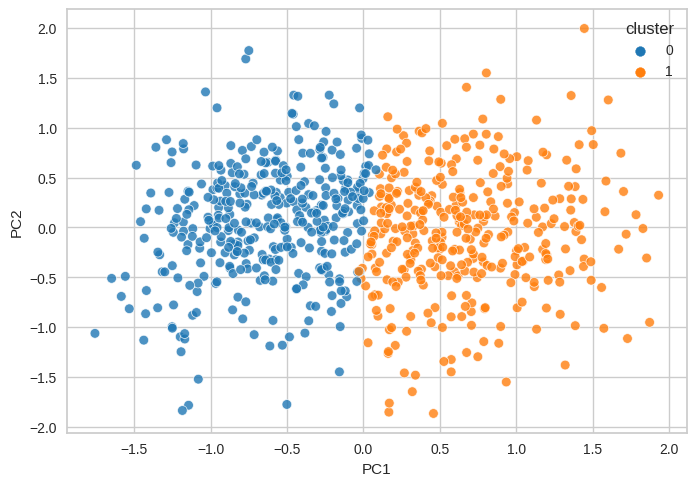

In [ ]:
# Creating K-means Cluster Model
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

seed = 1234  # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# Develop 2 PCA components for visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette='tab10', alpha=0.8)

In [ ]:
#pca_data.to_excel('pcaCV_pers_clusters.xlsx', index=False)

#Latent Profile Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid

# Using Stepmix library function to create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

# Result was found to be the same for n_steps = 1, 2 or 3 so only running for n_step = 1 to decrease cost
grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:04<00:00,  2.46it/s, max_LL=-1.68e+4, max_avg_LL=-23.2]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 59 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.8715 0.1285 0.9490 0.0510 0.9723 0.0277 0.9977 0.0023 0.8691 0.1309
 0.8916 0.1084 0.9542 0.0458 0.9815 0.0185 0.9350 0.0650 0.7833 0.2167
 0.9142 0.0858 0.9379 0.0621 0.8125 0.1875 0.9614 0.0386 0.8522 0.1478
 0.9090 0.0910 0.9456 0.0544 0.9406 0.0594 0.9068 0.0932 0.9872 0.0128
 0.9207 0.0793 0.8869 0.1131 0.7328 0.2672 0.8228 0.1772 0.9721 0.0279
 0.9338 0.0662 0.9613 0.0387 0.9892 0.0108 0.9093 0.0907 0.8440 0.1560
 0.9791 0.0209 0.9904 0.0096 0.8563 0.1437 0.8637 0.1363 0.8782 0.1218
 0.9213 0.0787 0.9113 0.0887 0.9244 0.0756 0.7437 0.2563 0.9949 0.

Initializations (n_init) : 100%|██████████| 10/10 [00:06<00:00,  1.61it/s, max_LL=-1.64e+4, max_avg_LL=-22.6]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 59 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.5894 0.4106 0.6818 0.3182 0.9037 0.0963 0.8153 0.1847 0.5943 0.4057
 0.6650 0.3350 0.8469 0.1531 0.8923 0.1077 0.6743 0.3257 0.3535 0.6465
 0.8023 0.1977 0.8976 0.1024 0.6332 0.3668 0.9468 0.0532 0.6861 0.3139
 0.7347 0.2653 0.8753 0.1247 0.7851 0.2149 0.7354 0.2646 0.9689 0.0311
 0.7003 0.2997 0.6557 0.3443 0.2735 0.7265 0.4984 0.5016 0.9671 0.0329
 0.8090 0.1910 0.9603 0.0397 0.9819 0.0181 0.8736 0.1264 0.6344 0.3656
 0.8136 0.1864 0.8477 0.1523 0.5022 0.4978 0.4505 0.5495 0.5616 0.4384
 0.6936 0.3064 0.7677 0.2323 0.8933 0.1067 0.4815 0.5185 0.9015 0.

Initializations (n_init) : 100%|██████████| 10/10 [00:19<00:00,  1.93s/it, max_LL=-1.61e+4, max_avg_LL=-22.2]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 59 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.4570 0.5430 0.5487 0.4513 0.8376 0.1624 0.7062 0.2938 0.4343 0.5657
 0.4948 0.5052 0.8004 0.1996 0.8410 0.1590 0.4860 0.5140 0.3388 0.6612
 0.7555 0.2445 0.8418 0.1582 0.5711 0.4289 0.9076 0.0924 0.6963 0.3037
 0.6916 0.3084 0.8054 0.1946 0.6844 0.3156 0.6097 0.3903 0.9345 0.0655
 0.4870 0.5130 0.4570 0.5430 0.2276 0.7724 0.3907 0.6093 0.9103 0.0897
 0.6686 0.3314 0.8788 0.1212 0.9356 0.0644 0.7420 0.2580 0.6088 0.3912
 0.7240 0.2760 0.7770 0.2230 0.4609 0.5391 0.4525 0.5475 0.4985 0.5015
 0.6689 0.3311 0.7094 0.2906 0.9012 0.0988 0.4664 0.5336 0.7876 0.

Initializations (n_init) : 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, max_LL=-1.6e+4, max_avg_LL=-22]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 59 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.8973 0.1027 0.9516 0.0484 0.9867 0.0133 1.0000 0.0000 0.9006 0.0994
 0.9447 0.0553 0.9704 0.0296 1.0000 0.0000 0.9569 0.0431 0.8461 0.1539
 0.9220 0.0780 0.9305 0.0695 0.9580 0.0420 0.9855 0.0145 0.9472 0.0528
 0.9577 0.0423 0.9892 0.0108 0.9707 0.0293 0.9377 0.0623 1.0000 0.0000
 0.9293 0.0707 0.9395 0.0605 0.8344 0.1656 0.8838 0.1162 1.0000 0.0000
 0.9622 0.0378 0.9951 0.0049 1.0000 0.0000 0.9229 0.0771 0.9417 0.0583
 1.0000 0.0000 0.9905 0.0095 0.9541 0.0459 0.9615 0.0385 0.9336 0.0664
 0.9680 0.0320 0.9415 0.0585 0.9608 0.0392 0.8297 0.1703 1.0000 0.

Initializations (n_init) : 100%|██████████| 10/10 [00:33<00:00,  3.34s/it, max_LL=-1.58e+4, max_avg_LL=-21.7]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 59 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.9041 0.0959 0.9898 0.0102 0.8827 0.1173 0.9848 0.0152 0.9275 0.0725
 0.8973 0.1027 0.9663 0.0337 0.9837 0.0163 0.9252 0.0748 0.7523 0.2477
 0.9721 0.0279 0.9600 0.0400 0.2790 0.7210 0.9251 0.0749 0.6225 0.3775
 0.7361 0.2639 0.7170 0.2830 0.7979 0.2021 0.6734 0.3266 1.0000 0.0000
 0.8531 0.1469 0.6780 0.3220 0.6691 0.3309 0.5885 0.4115 0.9637 0.0363
 0.7935 0.2065 0.9741 0.0259 0.9926 0.0074 0.8795 0.1205 0.3795 0.6205
 0.9212 0.0788 0.9784 0.0216 0.8702 0.1298 0.8978 0.1022 0.7235 0.2765
 1.0000 0.0000 0.7351 0.2649 0.9090 0.0910 0.6779 0.3221 0.9639 0.

Initializations (n_init) : 100%|██████████| 10/10 [00:26<00:00,  2.66s/it, max_LL=-1.57e+4, max_avg_LL=-21.6]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 59 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.8080 0.1920 0.9061 0.0939 1.0000 0.0000 0.9909 0.0091 0.8084 0.1916
 0.8166 0.1834 0.9206 0.0794 0.9718 0.0282 0.9002 0.0998 0.6148 0.3852
 0.8785 0.1215 0.9516 0.0484 0.9175 0.0825 0.9707 0.0293 0.8235 0.1765
 0.9178 0.0822 0.9838 0.0162 0.9673 0.0327 0.9693 0.0307 0.9869 0.0131
 0.9582 0.0418 0.9510 0.0490 0.5569 0.4431 0.7908 0.2092 0.9875 0.0125
 0.9769 0.0231 0.9734 0.0266 1.0000 0.0000 0.9487 0.0513 0.9847 0.0153
 0.9581 0.0419 0.9885 0.0115 0.6261 0.3739 0.5545 0.4455 0.8588 0.1412
 0.7376 0.2624 0.9549 0.0451 0.8507 0.1493 0.5987 0.4013 1.0000 0.

Initializations (n_init) : 100%|██████████| 10/10 [00:36<00:00,  3.67s/it, max_LL=-1.56e+4, max_avg_LL=-21.5]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 59 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.5117 0.4883 0.6566 0.3434 0.8788 0.1212 0.9411 0.0589 0.5196 0.4804
 0.6298 0.3702 0.8539 0.1461 0.8085 0.1915 0.5936 0.4064 0.6230 0.3770
 0.6163 0.3837 0.8288 0.1712 0.8745 0.1255 0.9846 0.0154 0.9367 0.0633
 0.8658 0.1342 1.0000 0.0000 0.8272 0.1728 0.8661 0.1339 1.0000 0.0000
 0.6031 0.3969 0.5760 0.4240 0.4261 0.5739 0.5849 0.4151 1.0000 0.0000
 0.9288 0.0712 0.9869 0.0131 1.0000 0.0000 1.0000 0.0000 0.8812 0.1188
 0.8441 0.1559 0.9333 0.0667 0.8981 0.1019 0.7644 0.2356 0.7112 0.2888
 0.8968 0.1032 0.9043 0.0957 0.9839 0.0161 0.6589 0.3411 1.0000 0.

Initializations (n_init) : 100%|██████████| 10/10 [00:32<00:00,  3.26s/it, max_LL=-1.55e+4, max_avg_LL=-21.3]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 59 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.8054 0.1946 0.8776 0.1224 1.0000 0.0000 1.0000 0.0000 0.8089 0.1911
 0.8580 0.1420 0.9683 0.0317 0.9861 0.0139 0.9746 0.0254 0.3998 0.6002
 0.9130 0.0870 0.9362 0.0638 0.9185 0.0815 0.9213 0.0787 0.8589 0.1411
 0.9885 0.0115 0.9706 0.0294 0.9443 0.0557 0.9747 0.0253 0.9882 0.0118
 0.9469 0.0531 0.9723 0.0277 0.4780 0.5220 0.6512 0.3488 0.9648 0.0352
 0.9459 0.0541 0.9312 0.0688 1.0000 0.0000 0.9480 0.0520 1.0000 0.0000
 1.0000 0.0000 0.9808 0.0192 0.6237 0.3763 0.7560 0.2440 0.8133 0.1867
 0.9682 0.0318 0.9482 0.0518 0.8929 0.1071 0.5395 0.4605 1.0000 0.

In [ ]:
# Printing desired AIC and BIC values from Stepmix
results[['param_n_components', 'aic', 'bic']].round().astype(int)


,param_n_components,aic,bic
0,2,33915,34461
1,3,33246,34067
2,4,32767,33864
3,5,32524,33896
4,6,32333,33981
5,7,32221,34144
6,8,32169,34367
7,9,32101,34575
